## NSMC를 딥러닝(LSTM)으로 분석

### Text tokenizing

In [1]:
import MeCab
from konlpy.tag import Okt

import json
import os
import re
from pprint import pprint

mecab = MeCab.Tagger()

if os.path.exists('data/train_docs.json'):
    with open("data/train_docs.json", encoding='utf-8') as f:
        train_data = json.load(f)
else:
    train_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in train_docs if text_tokenizing(text_cleaning(line[1]))]    
    # 전처리 안함
    #train_data = [(text_tokenizing(line[1]), line[2]) for line in train_docs if text_tokenizing(line[1])]
    with open("data/train_docs.json", 'w', encoding='utf-8') as f:
        json.dump(train_data, f, ensure_ascii=False, indent='\t')
        
if os.path.exists('data/test_docs.json'):
    with open("data/test_docs.json", encoding='utf-8') as f:
        test_data = json.load(f)
else:
    test_data = [(text_tokenizing(text_cleaning(line[1])), line[2]) for line in test_docs if text_tokenizing(text_cleaning(line[1]))]
    # 전처리 안함
    #test_data = [(text_tokenizing(line[1]), line[2]) for line in test_docs if text_tokenizing(line[1])]
    with open("data/test_docs.json", 'w', encoding='utf-8') as f:
        json.dump(test_data, f, ensure_ascii=False, indent='\t')

pprint(train_data[0])
pprint(test_data[0])

[['진짜', '짜증', '네요', '목소리'], '0']
[['평점', '나쁘', '지만', '짜리', '더더욱', '아니', '잖아'], '0']


In [2]:
print(len(train_data))
print(len(test_data))

146211
48792


## Deep Neural Network로 분류하기

In [9]:
# 필요한 라이브러리 불러오기
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.data import Dataset

In [5]:
tf.__version__

'2.3.1'

## Set Hyperparameter 

In [6]:
max_words = 35000   # 전체 14만 토큰을 모두 사용하지 않음
max_len = 30
batch_size = 64
EPOCHS = 5

## Define Network Structure 

In [7]:
class SimpleLSTM(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.embed = Embedding(max_words, 100)
        self.lstm = LSTM(64, dropout=0.2, recurrent_dropout=0.2)
        self.dense = Dense(1, activation="sigmoid")
        
    def __call__(self, x, training=None, mask=None):
        x = self.embed(x)
        x = self.lstm(x)
        return self.dense(x)

## Data Preprocessing 

In [12]:
pprint(train_data[0])

# SVM 때와 비슷한 형태로 만들고
x_train = [doc for doc, _ in train_data]

# keras가 사용하기 위한 형태로 Tokenizing
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(x_train)

# LSTM의 input으로 넣기 위한 변환 작업
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences([doc for doc, _ in test_data])

y_train = np.array([int(label) for _, label in train_data])  # int to array
y_test = np.array([int(label) for _, label in test_data])

print(x_train[0])

# 크기를 맞춰주기 위한 zero padding
x_train = pad_sequences(x_train, value=0, padding='pre', maxlen=max_len) # pre - 앞에서부터 채움
x_test = pad_sequences(x_test, value=0, padding='pre', maxlen=max_len)

print(x_train[0])

# 학습 가능한 형태로 최종 변환.
train_ds = Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(batch_size)
test_ds = Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

[['진짜', '짜증', '네요', '목소리'], '0']
[8, 109, 6, 455]
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   8 109   6 455]


## Set Model 

In [14]:
model = SimpleLSTM()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Early Stopping Callback

In [15]:
earlystopper = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, verbose=1)

## Run Model 

In [17]:
# 실행, 결과 저장.
history = model.fit(train_ds, validation_data=test_ds, epochs=EPOCHS, callbacks=earlystopper)

Epoch 1/5
2285/2285 [==============================] - 135s 59ms/step - loss: 0.4079 - accuracy: 0.8099 - val_loss: 0.3811 - val_accuracy: 0.8261
Epoch 2/5
2285/2285 [==============================] - 136s 59ms/step - loss: 0.3204 - accuracy: 0.8589 - val_loss: 0.4017 - val_accuracy: 0.8241
Epoch 3/5
2285/2285 [==============================] - 134s 59ms/step - loss: 0.2612 - accuracy: 0.8874 - val_loss: 0.4454 - val_accuracy: 0.8183
Epoch 4/5
2285/2285 [==============================] - 135s 59ms/step - loss: 0.2118 - accuracy: 0.9100 - val_loss: 0.5131 - val_accuracy: 0.8089
Epoch 5/5
2285/2285 [==============================] - 139s 61ms/step - loss: 0.1766 - accuracy: 0.9255 - val_loss: 0.5826 - val_accuracy: 0.8049


In [18]:
# Model Test
score, acc = model.evaluate(x_test, y_test)

1525/1525 [==============================] - 4s 3ms/step - loss: 0.5826 - accuracy: 0.8049


In [19]:
print("Test Score: ", score)
print("Test Accuracy: ", acc)

Test Score:  0.5826334357261658
Test Accuracy:  0.804947555065155


## Loss Visualization 

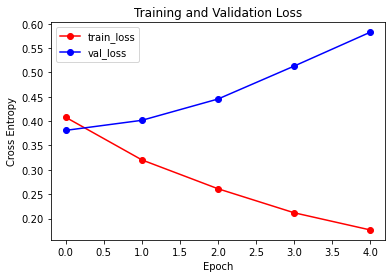

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(loss, 'ro-', label="train_loss")
plt.plot(val_loss, 'bo-', label="val_loss")
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.title('Training and Validation Loss')
plt.show()

## Save Weight 

In [22]:
# Model weight matrix 저장.
model.save_weights('nsmc_keras_simpleLSTM')